In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [2]:
model_path = '../pickle/RandomForest/gptNeo_model.pkl'

In [3]:
# Load data 
data = pd.read_csv('../../preprocessing/StorePreprocessed/GPTNeocsv.csv')

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data["text"], data["label"], test_size=0.2, random_state=42, stratify=data["label"])

In [5]:
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(4, 4), max_features=11000)  # dynamic range of features

In [6]:
# Remove NaN values from the split data
X_train = X_train.dropna()
X_test = X_test.dropna()
y_train = y_train[X_train.index]
y_test = y_test[X_test.index]

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [7]:
#define gridsearch parameters
param_grid_rf = {
    'min_samples_split': [8, 32, 128],
    'max_features': [int(np.sqrt(X_train.shape[1])), int(0.02 * X_train.shape[1]), int(0.04 * X_train.shape[1]), int(0.06 * X_train.shape[1])]
}

In [8]:
rf = RandomForestClassifier(criterion='gini', oob_score=True)

In [9]:
# Grid search for Random Forest
if os.path.exists(model_path):

    with open(model_path, 'rb') as file:
        rf_best = pickle.load(file)
else:
    grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy')
    grid_rf.fit(X_train, y_train)
    rf_best = grid_rf.best_estimator_
y_pred_rf = rf_best.predict(X_test)

In [10]:
with open(model_path, 'wb') as file:
    pickle.dump(rf_best, file)

In [11]:
# Evaluate Random Forest
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.84      0.79      2000
           1       0.82      0.71      0.76      1975

    accuracy                           0.78      3975
   macro avg       0.78      0.78      0.78      3975
weighted avg       0.78      0.78      0.78      3975

Random Forest Accuracy: 0.7763522012578616


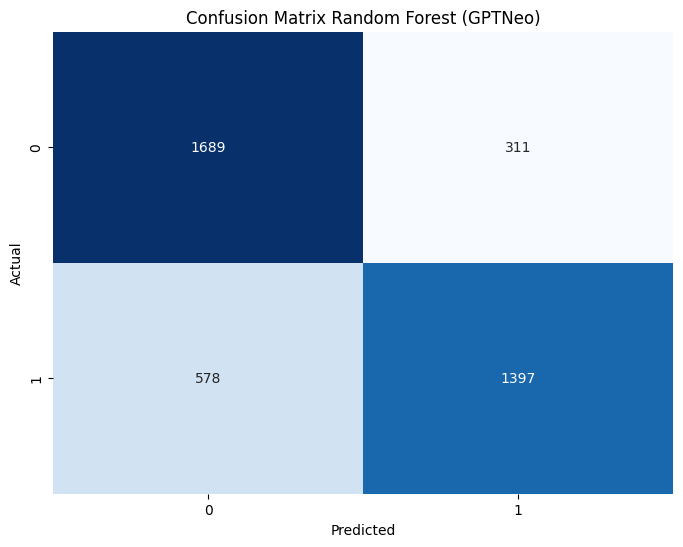

In [12]:
cm = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Random Forest (GPTNeo)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('../../evaluation/GPTNeo_Evaluation/Confusion_Matrix_RandomForest.png')
plt.show()